# Step 1 - Import and init

In [51]:
import sys, os
import urllib

import tensorflow as tf
from tensorflow import keras

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

# tf.keras.utils.set_random_seed(42)
sns.set()

# Step 2 - Retrieve the data

## 2.1 Fetch the data online

In [52]:
WINE_URL = r'https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv'
WINE_DIR = os.path.join("..", "datasets", "wine")

def fetch_wine_data(wine_url=WINE_URL, wine_dir=WINE_DIR):
    os.makedirs(wine_dir, exist_ok=True)
    csv_path = os.path.join(wine_dir, 'wine.csv')
    urllib.request.urlretrieve(wine_url, csv_path)

fetch_wine_data()

## 2.2 Load the data in memory

In [53]:
def load_wine_data(wine_dir=WINE_DIR):
    csv_path = os.path.join(wine_dir, 'wine.csv')
    return pd.read_csv(csv_path, sep=";")

wine = load_wine_data()

## 2.3 Inspect the data

In [54]:
def describe_dataframe(df, disp_names=True):
    print(f'Variable type : {type(df)}')
    print(f'Shape : {df.shape}')
    if isinstance(df, pd.DataFrame) and disp_names:
        print(f'Column names :')
        for name in df.columns:
            print('\t', name)
    print(f'Missing data : {df.isna().sum().sum()}')
    print(f'First indices : {list(df.index[:5])}')

describe_dataframe(wine)
wine.head()

Variable type : <class 'pandas.core.frame.DataFrame'>
Shape : (1599, 12)
Column names :
	 fixed acidity
	 volatile acidity
	 citric acid
	 residual sugar
	 chlorides
	 free sulfur dioxide
	 total sulfur dioxide
	 density
	 pH
	 sulphates
	 alcohol
	 quality
Missing data : 0
First indices : [0, 1, 2, 3, 4]


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


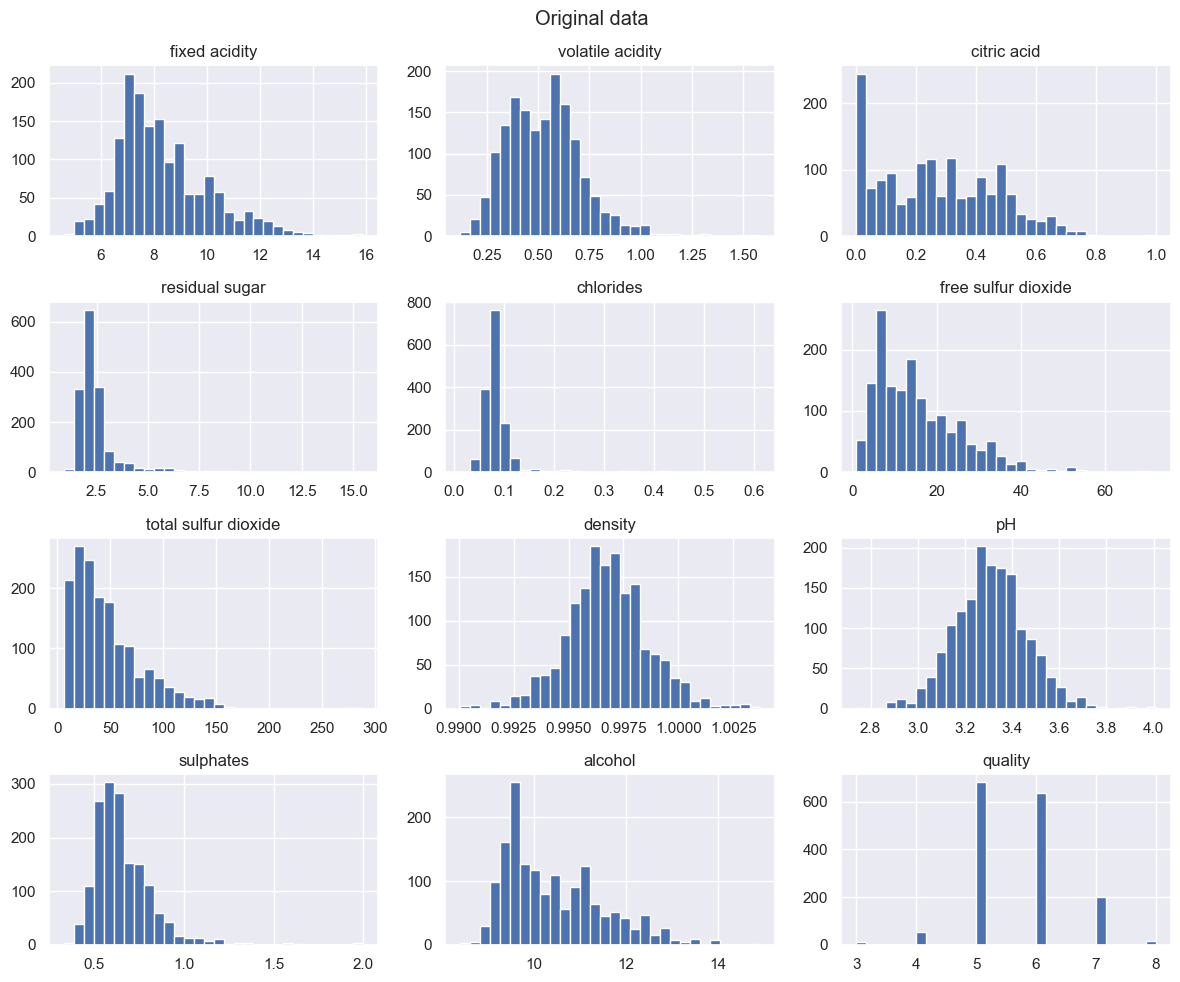

In [55]:
def visualize_data(df, title=None):
    df.hist(bins=30, figsize=(12, 10))
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()
    
visualize_data(wine, title='Original data')

# Step 3 - Preparing the data

## 3.1 - Split the data

In [56]:
def split_train_test(data, test_ratio):
    rng = np.random.default_rng(42)
    shuffled_indices = rng.permutation(len(data))
    test_set_size = int(test_ratio*len(data))
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

train_set, test_set = split_train_test(wine, 0.8)

x_train = train_set.drop('quality', axis=1)
y_train = train_set['quality']

x_test = test_set.drop('quality', axis=1)
y_test = test_set['quality']

for name, var in zip(['x_train', 'y_train', 'x_test', 'y_test'], [x_train, y_train, x_test, y_test]):
    print(f'\n{name}')
    describe_dataframe(var, disp_names=False)


x_train
Variable type : <class 'pandas.core.frame.DataFrame'>
Shape : (320, 11)
Missing data : 0
First indices : [709, 19, 1186, 16, 1089]

y_train
Variable type : <class 'pandas.core.series.Series'>
Shape : (320,)
Missing data : 0
First indices : [709, 19, 1186, 16, 1089]

x_test
Variable type : <class 'pandas.core.frame.DataFrame'>
Shape : (1279, 11)
Missing data : 0
First indices : [595, 868, 713, 150, 470]

y_test
Variable type : <class 'pandas.core.series.Series'>
Shape : (1279,)
Missing data : 0
First indices : [595, 868, 713, 150, 470]


## 3.2 Data standardization

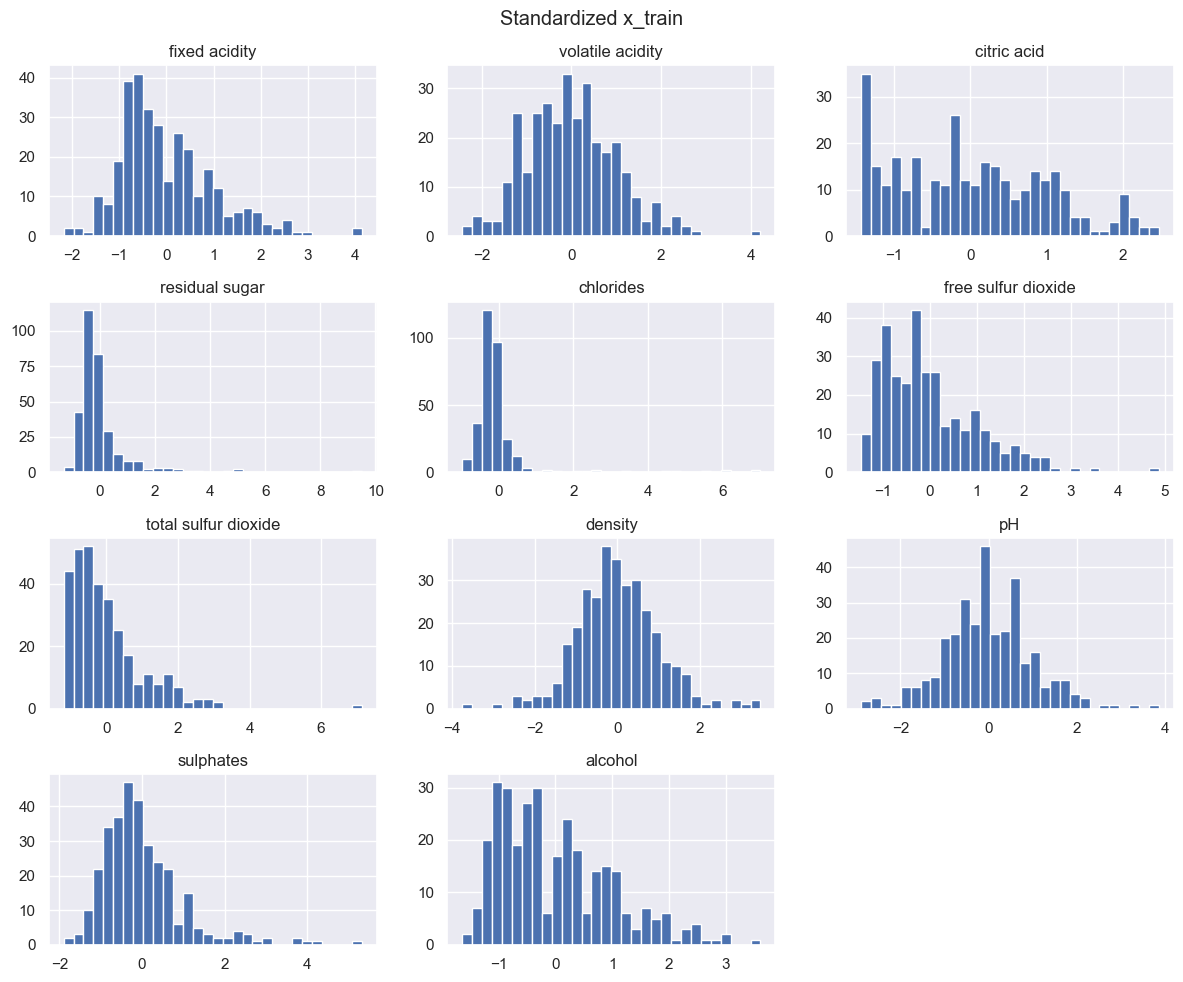

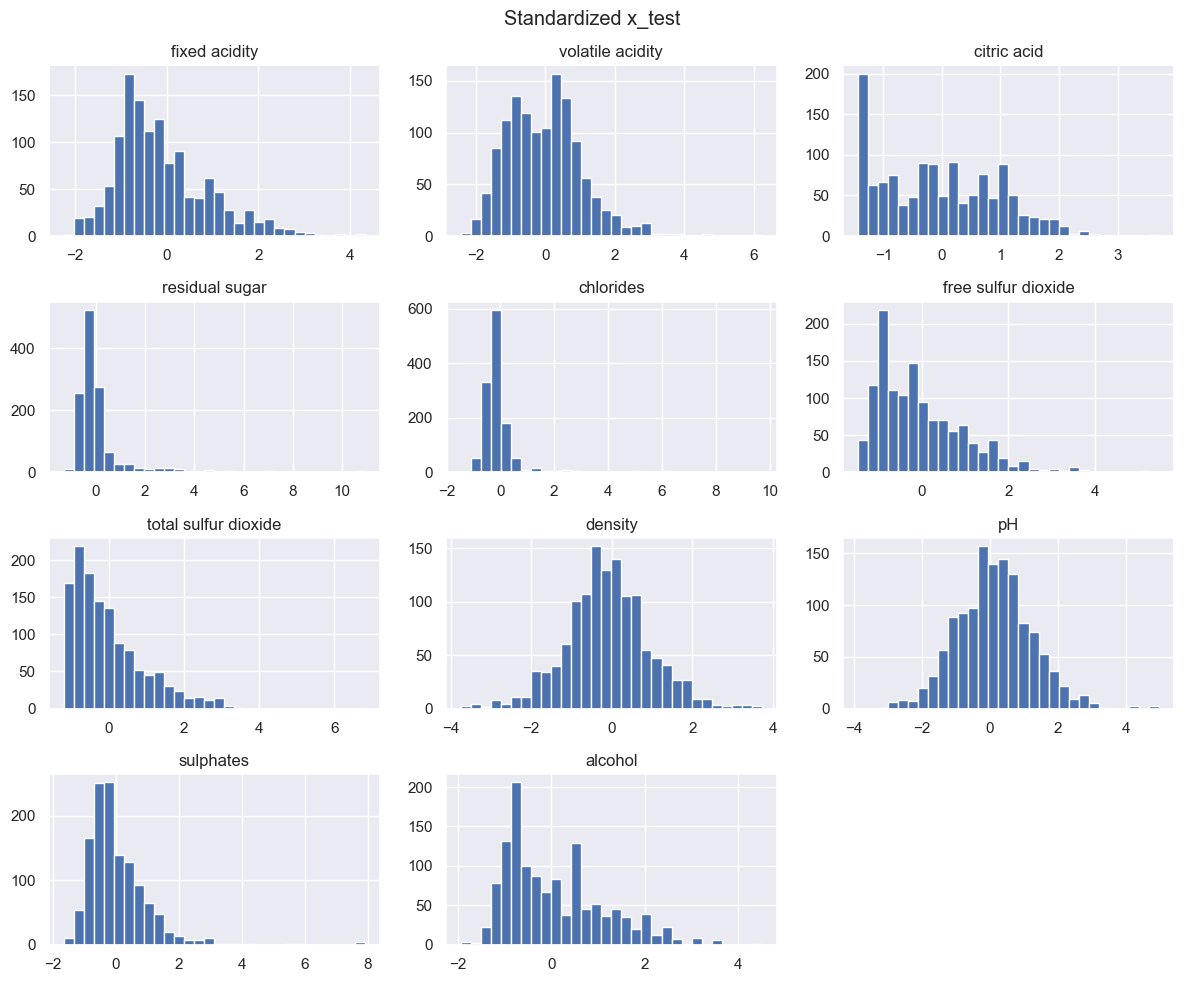

In [57]:
def standardize_data(train, test):
    mean, std = train.mean(), train.std()
    train = (train-mean)/std
    test = (test-mean)/std
    return train, test

x_train, x_test = standardize_data(x_train, x_test)

visualize_data(x_train, title='Standardized x_train')

visualize_data(x_test, title='Standardized x_test')

# Step 4 - Build the model

In [58]:
def get_model(input_shape, name=None, summary=True):
    
    model = keras.models.Sequential(name=name)
    model.add(keras.layers.Input(input_shape, name="InputLayer"))
    model.add(keras.layers.Dropout(0.1))
    model.add(keras.layers.Dense(64, activation="relu", name="Dense_1"))
    model.add(keras.layers.Dropout(0.2))
    model.add(keras.layers.Dense(64, activation="relu", name="Dense_2"))
    model.add(keras.layers.Dropout(0.2))
    model.add(keras.layers.Dense(1, name="Output"))
    
    model.compile(
        optimizer = "rmsprop",
        loss = "mse",
        metrics = ["mae", "mse"],
    )
    
    if summary:
        model.summary() 
        
    return model

# Step 5 - Train the model

## 5.1 Get the model

In [60]:
model = get_model(11, name="wine_quality")

Model: "wine_quality"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_12 (Dropout)        (None, 11)                0         
                                                                 
 Dense_1 (Dense)             (None, 64)                768       
                                                                 
 dropout_13 (Dropout)        (None, 64)                0         
                                                                 
 Dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dropout_14 (Dropout)        (None, 64)                0         
                                                                 
 Output (Dense)              (None, 1)                 65        
                                                                 
Total params: 4,993
Trainable params: 4,993
Non-traina

## 5.2 Define callbacks

In [61]:
MODELS_DIR = os.path.join('..', 'models', 'wine')
os.makedirs(os.path.dirname(MODELS_DIR), exist_ok=True)

savemodel = tf.keras.callbacks.ModelCheckpoint(
    filepath=os.path.join(MODELS_DIR, f'{model.name}.h5'),
    save_best_only=True,
    verbose=False,
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.8,
    patience=10,
    min_lr=0.0005,
    verbose=False,
)

stop_early = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=100,
)

## 5.3 Train the model

In [62]:
history = model.fit(
    x_train,
    y_train,
    epochs=1000,
    batch_size=10,
    validation_data=(x_test, y_test),
    callbacks=[savemodel, reduce_lr, stop_early],
    verbose=False,
)

# Step 6 - Evaluate the model

## 6.1 Model evaluation

In [63]:
def evaluate_model(model, x_test, y_test):
    score = model.evaluate(x_test, y_test, verbose=True)
    print(f'loss:{score[0]:.4f}, mae:{score[1]:.4f}, mse:{score[2]:.4f}')
    
evaluate_model(model, x_test, y_test)

40/40 [==============================] - 0s 2ms/step - loss: 0.4392 - mae: 0.4998 - mse: 0.4392
loss:0.4392, mae:0.4998, mse:0.4392


## 6.2 Training history

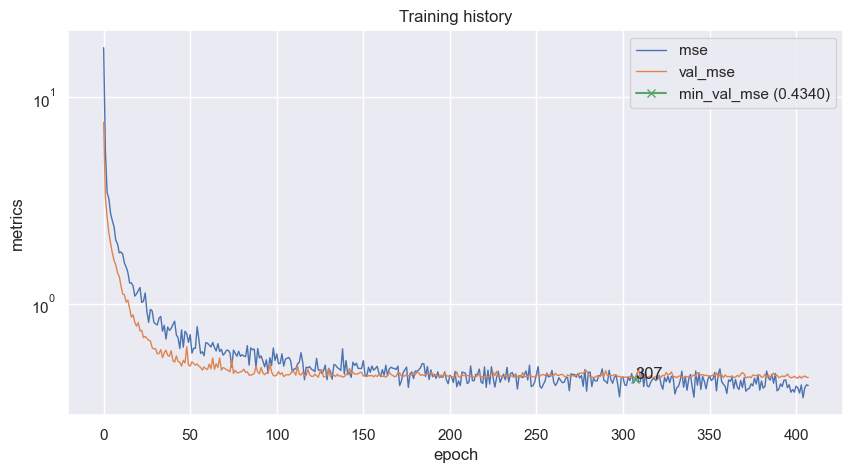

In [64]:
def best_perf(values, mode):
    if mode == 'min':
        i = np.argmin(values)
    elif mode == 'max':
        i = np.argmax(values)
    return i, values[i]

def plot_history(history, labels, dots=None, title=None, savepath=None):
    plt.figure(figsize=(10,5))
    plt.title(title)
    for label in labels:
        plt.plot(history.epoch, history.history[label], label=label, linewidth=1)
    if dots is not None:
        for label, modes in dots.items():
            for mode in modes:
                best_epoch, best_epoch_value = best_perf(history.history[label], mode)
                plt.plot(best_epoch, best_epoch_value, marker='x', label=f'{mode}_{label} ({best_epoch_value:.4f})')
                plt.annotate(best_epoch, (best_epoch,best_epoch_value))
    plt.xlabel('epoch')
    plt.ylabel('metrics')
    plt.legend()
    plt.semilogy()
    if savepath is not None:
        plt.savefig(savepath, bbox_inches='tight')
    plt.show()

# print(history.history.keys())

plot_history(
    history,
    ["mse", "val_mse"],
    dots={'val_mse':['min']},
    title='Training history',
    savepath=os.path.join(MODELS_DIR, f'{model.name}_history.png')
)

# Step 7 - Restore a model

## 7.1 Reload the model

In [65]:
loaded_model = tf.keras.models.load_model(os.path.join(MODELS_DIR, 'wine_quality.h5'))
loaded_model.summary()

Model: "wine_quality"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_12 (Dropout)        (None, 11)                0         
                                                                 
 Dense_1 (Dense)             (None, 64)                768       
                                                                 
 dropout_13 (Dropout)        (None, 64)                0         
                                                                 
 Dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dropout_14 (Dropout)        (None, 64)                0         
                                                                 
 Output (Dense)              (None, 1)                 65        
                                                                 
Total params: 4,993
Trainable params: 4,993
Non-traina

## 7.2 Evaluate it

In [66]:
evaluate_model(loaded_model, x_test, y_test)

40/40 [==============================] - 0s 1ms/step - loss: 0.4340 - mae: 0.5008 - mse: 0.4340
loss:0.4340, mae:0.5008, mse:0.4340


## 7.3 Make predictions

In [67]:
def inference(model, x_sample, y_sample):
    y_preds = model.predict(x_sample)
    for y_true, y_pred in zip(y_sample, y_preds):
        print(f'Pred: {y_pred[0]:.2f} - Pred_int: {y_pred[0]:.0f} - True: {y_true} - Error:{abs(y_pred[0]-y_true):.2f}')

n_samples = 10
indices = np.random.default_rng(42).integers(low=0, high=len(x_test), size=n_samples)
x_sample = x_test.iloc[indices]
y_sample = y_test.iloc[indices]

inference(loaded_model, x_sample, y_sample)

1/1 [==============================] - 0s 59ms/step
Pred: 6.06 - Pred_int: 6 - True: 6 - Error:0.06
Pred: 5.46 - Pred_int: 5 - True: 5 - Error:0.46
Pred: 4.94 - Pred_int: 5 - True: 6 - Error:1.06
Pred: 5.46 - Pred_int: 5 - True: 6 - Error:0.54
Pred: 6.09 - Pred_int: 6 - True: 7 - Error:0.91
Pred: 5.05 - Pred_int: 5 - True: 5 - Error:0.05
Pred: 6.17 - Pred_int: 6 - True: 8 - Error:1.83
Pred: 4.62 - Pred_int: 5 - True: 5 - Error:0.38
Pred: 6.11 - Pred_int: 6 - True: 6 - Error:0.11
Pred: 5.12 - Pred_int: 5 - True: 4 - Error:1.12
